# Causal Analysis of Sociopolitical Events on Crime Trends in Los Angeles

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

## Loading Dataset

In [2]:
# Load the crime datasets
crime_data = pd.read_csv('data/processed-data/weekly_crime_summary.csv')
DP05_data = pd.read_csv('data/processed-data/DP05_combined.csv')
S1401_data = pd.read_csv('data/processed-data/S1401_combined.csv')

# Merge all three datasets
merged_data = pd.merge(crime_data, DP05_data, on=['Date', 'Area'], how='inner')
merged_data = pd.merge(merged_data, S1401_data, on=['Date', 'Area'], how='inner')

## Exploratory Data Analysis

### Correlation Heatmap

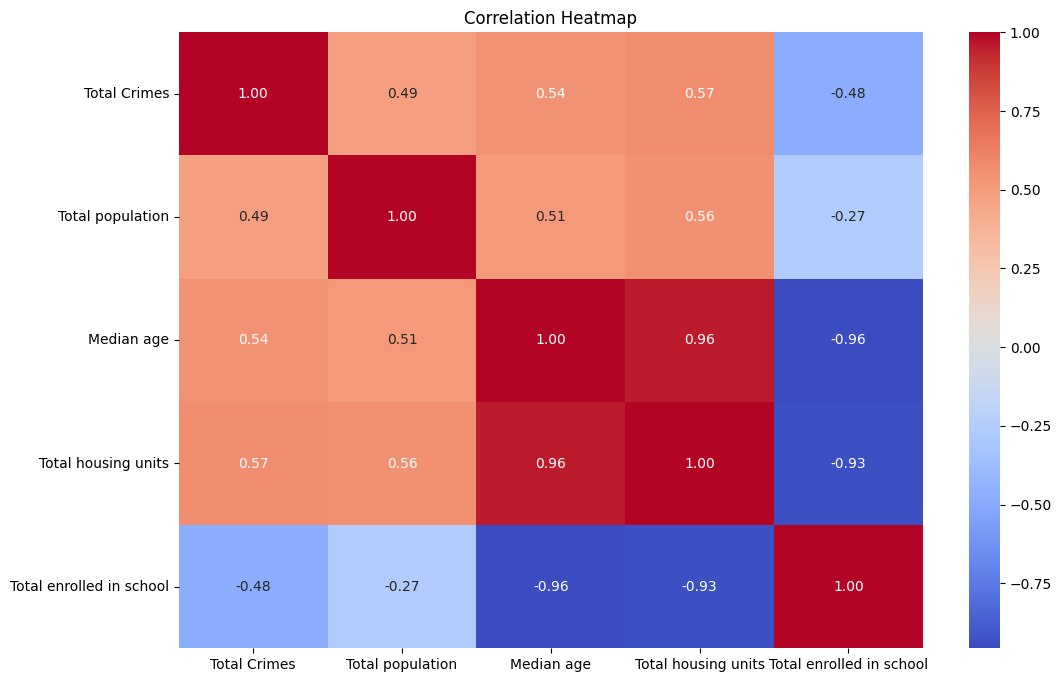

In [3]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation
numeric_data = merged_data.select_dtypes(include=['number'])
numeric_data = ['Total Crimes', 'Total population', 'Median age', 'Total housing units', 'Total enrolled in school']
sns.heatmap(merged_data[merged_data['Area'] == 'Los Angeles'][numeric_data].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Distribution Graphs

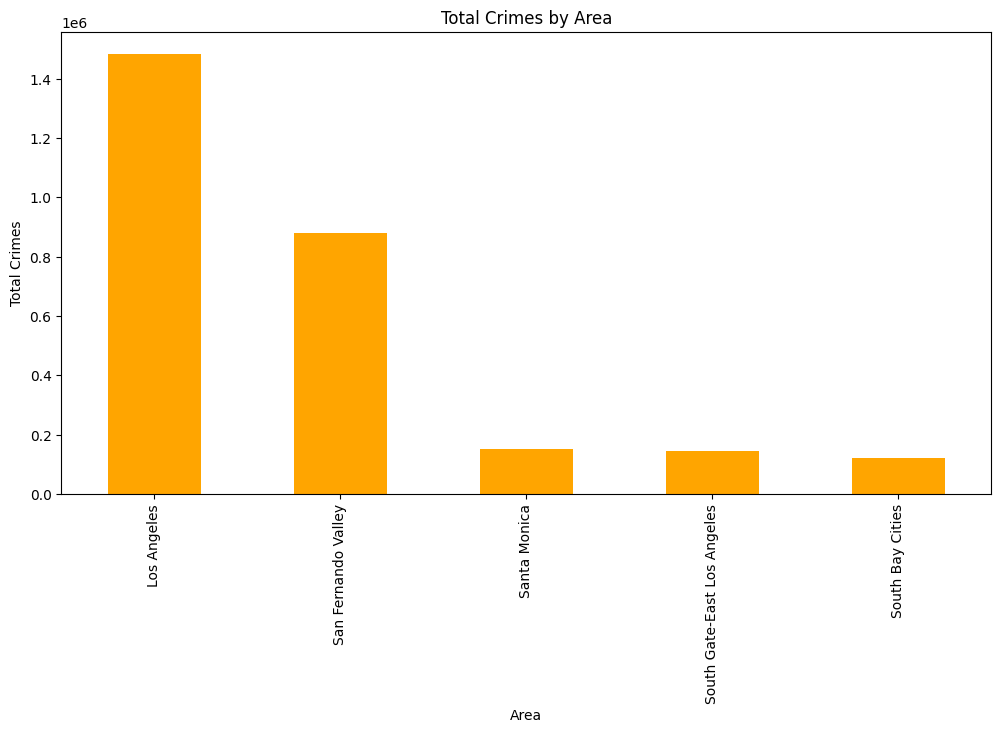

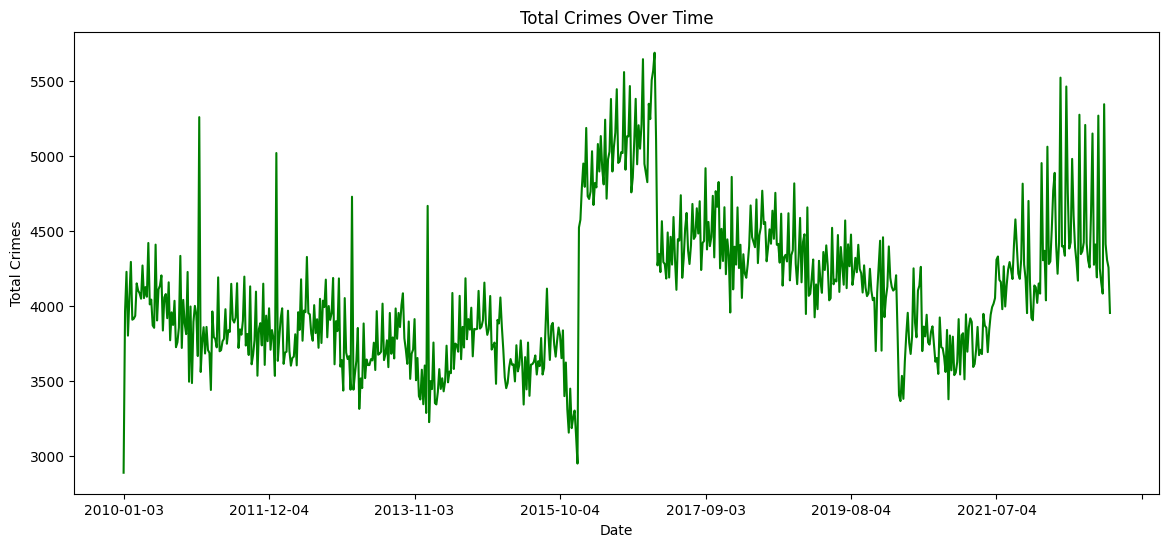

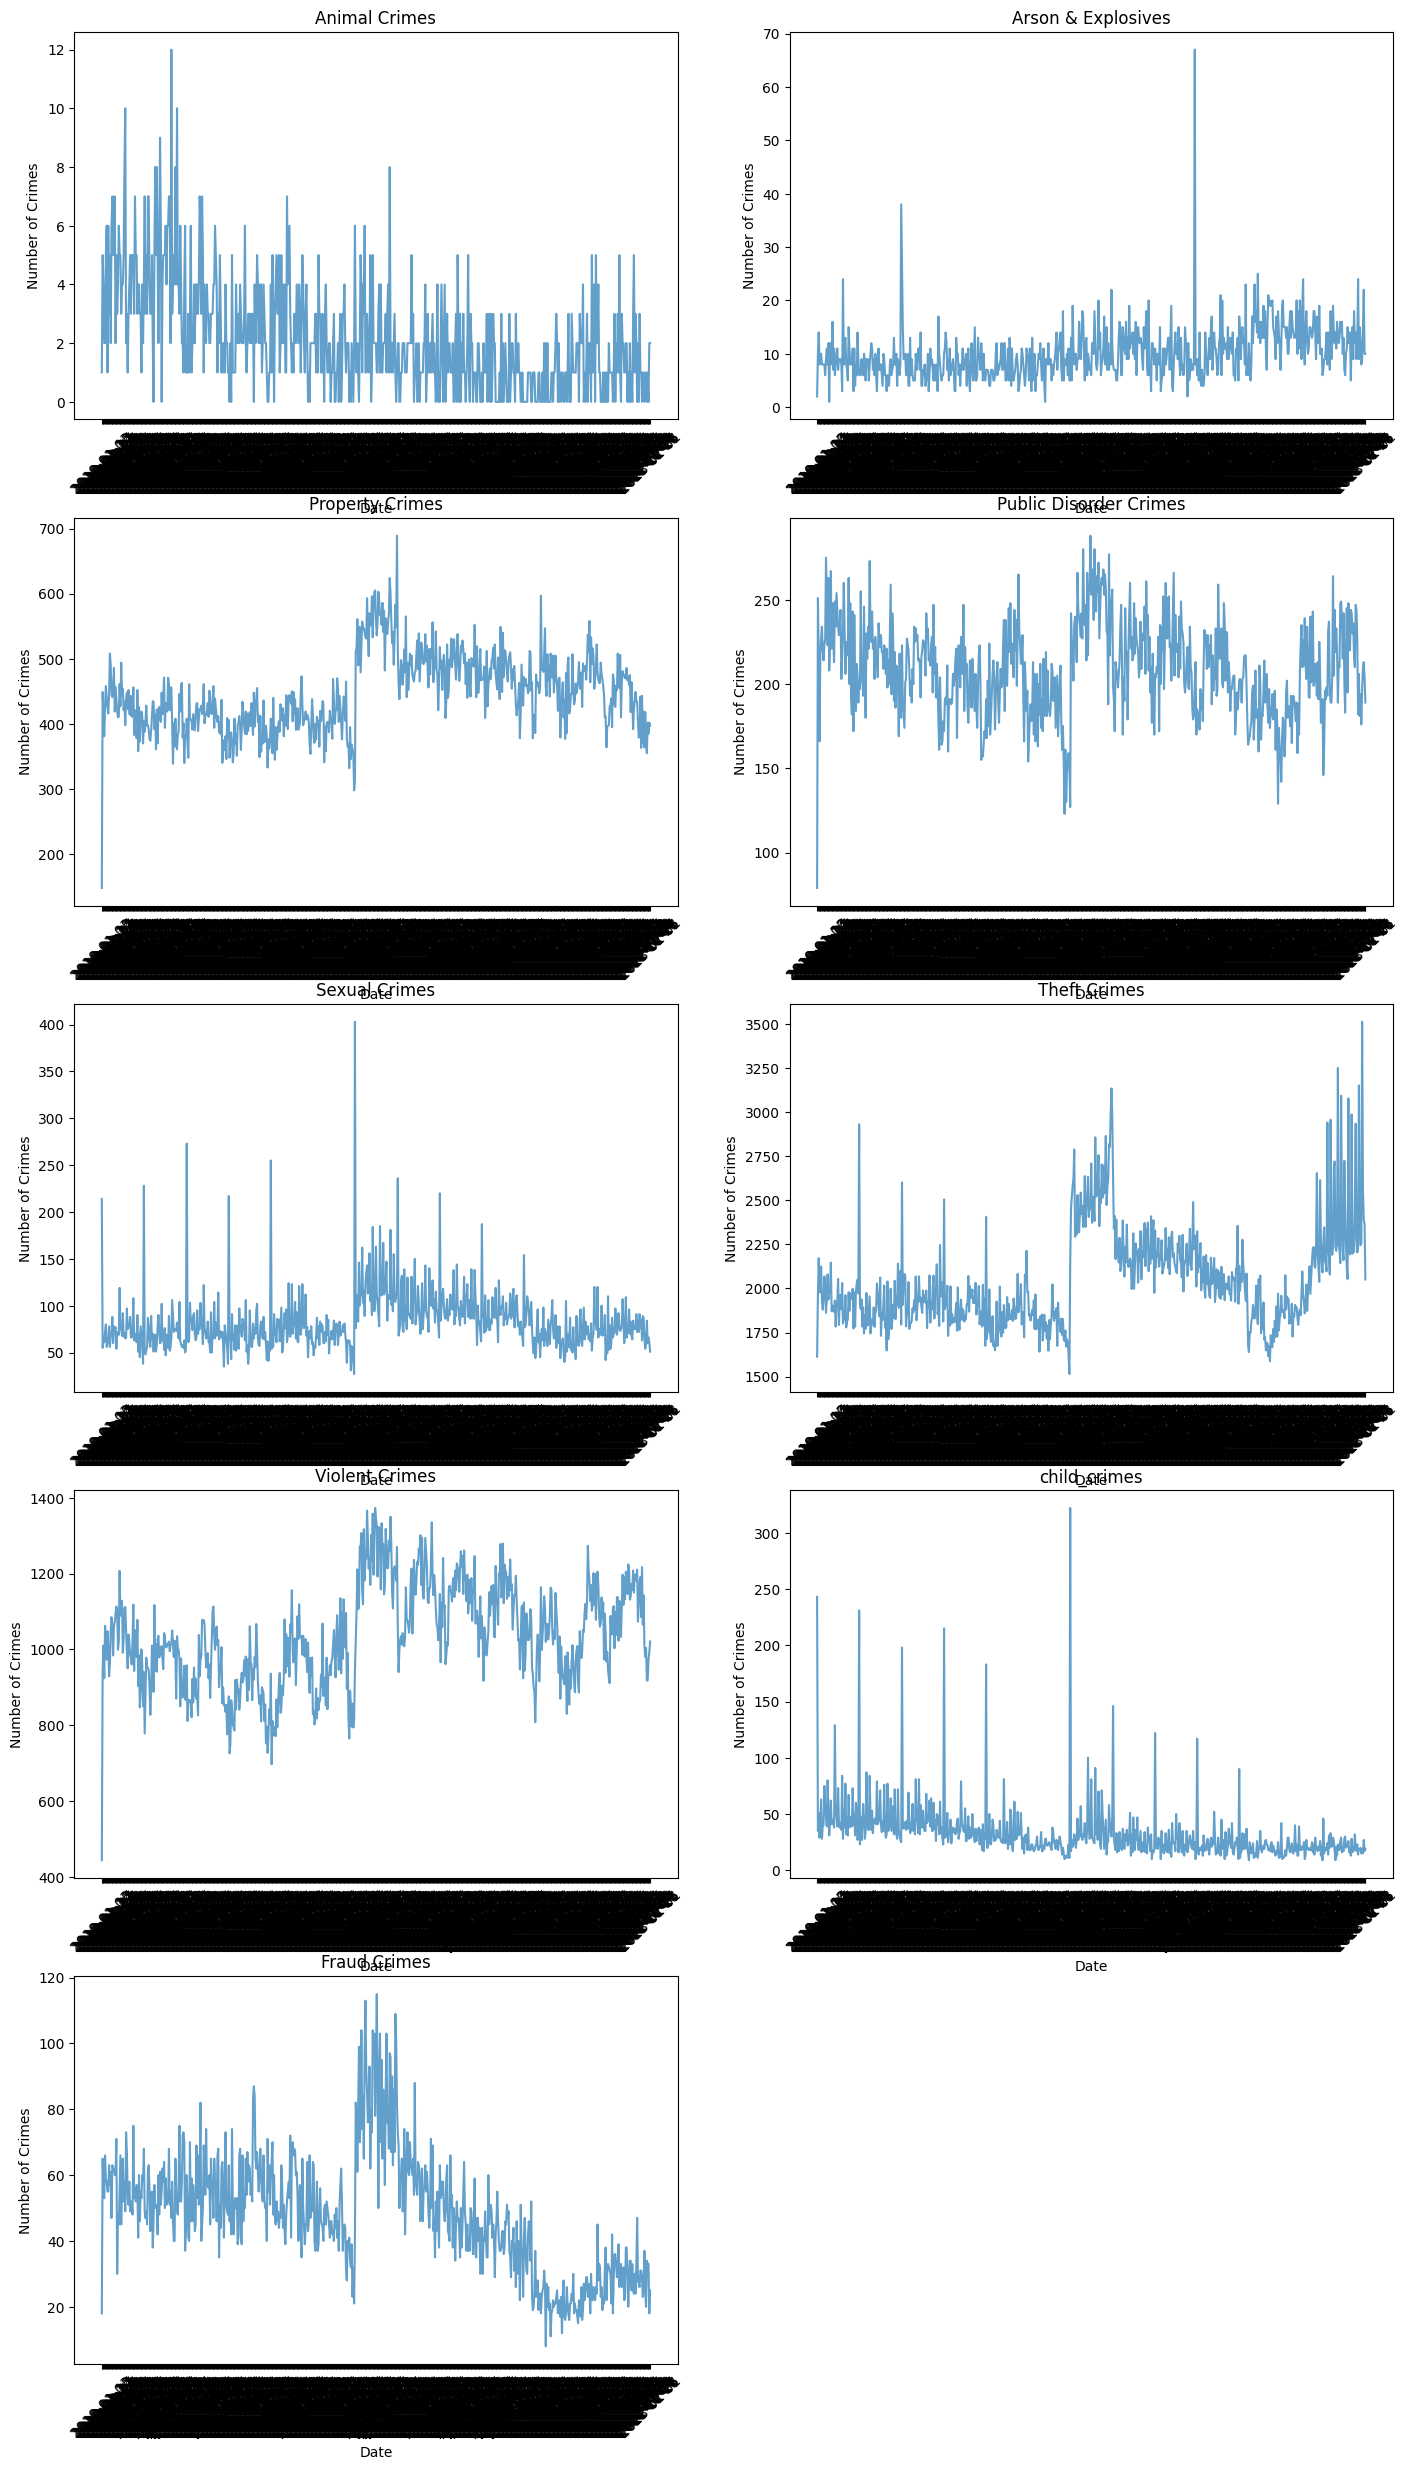

In [4]:
# Crimes by Area
plt.figure(figsize=(12, 6))
area_crimes = merged_data.groupby('Area')['Total Crimes'].sum().sort_values(ascending=False)
area_crimes.plot(kind='bar', color='orange')
plt.title("Total Crimes by Area")
plt.xlabel("Area")
plt.ylabel("Total Crimes")
plt.show()

# Crimes over time
crimes_over_time = merged_data.groupby('Date')['Total Crimes'].sum()
plt.figure(figsize=(14, 6))
crimes_over_time.plot(color='green')
plt.title("Total Crimes Over Time")
plt.xlabel("Date")
plt.ylabel("Total Crimes")
plt.show()

# Plot time series for each crime subcategory
crime_categories = ['Animal Crimes', 'Arson & Explosives', 'Property Crimes', 
                   'Public Disorder Crimes', 'Sexual Crimes', 'Theft Crimes', 
                   'Violent Crimes', 'child_crimes', 'Fraud Crimes']

# Calculate the number of rows and columns for the grid
num_cols = 2
num_rows = (len(crime_categories) + num_cols - 1) // num_cols

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.tight_layout(pad=5.0)

# Loop through each crime category and plot in a separate subplot
for i, category in enumerate(crime_categories):
    ax = axes[i // num_cols, i % num_cols]  # Determine the subplot to use
    crimes_by_category = merged_data.groupby('Date')[category].sum()
    ax.plot(crimes_by_category, label=category, alpha=0.7)
    ax.set_title(category)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Crimes")
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of categories is not a multiple of num_cols
if len(crime_categories) % num_cols != 0:
    for i in range(len(crime_categories), num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

plt.show()

## Causal Analysis

### Proposition 47 enactment - Regression Discontinuity

In [5]:
cutoff_date = pd.to_datetime('2014-11-04')

# Convert 'Date' column to datetime objects
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Running variable: Weeks from cutoff
merged_data['weeks_since_cutoff'] = (merged_data['Date'] - cutoff_date).dt.days / 7

# Treatment indicator
merged_data['treated'] = (merged_data['weeks_since_cutoff'] >= 0).astype(int)

bandwidth_weeks = 56  # two years around the cutoff
rd_data = merged_data[(merged_data['weeks_since_cutoff'] >= -bandwidth_weeks) & (merged_data['weeks_since_cutoff'] <= bandwidth_weeks)]

In [6]:
rd_data.rename(columns={'Total Crimes': 'Total_Crimes'}, inplace=True)
rd_data = rd_data[rd_data['Area'] == 'Los Angeles']

formula = 'Total_Crimes ~ weeks_since_cutoff + treated + weeks_since_cutoff:treated'
rd_model = smf.ols(formula, data=rd_data).fit()

print(rd_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Total_Crimes   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     19.81
Date:                Fri, 09 May 2025   Prob (F-statistic):           2.63e-10
Time:                        18:54:58   Log-Likelihood:                -679.42
No. Observations:                 112   AIC:                             1367.
Df Residuals:                     108   BIC:                             1378.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

C:\Users\mohi2\AppData\Local\Temp\ipykernel_9888\112375190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rd_data.rename(columns={'Total Crimes': 'Total_Crimes'}, inplace=True)


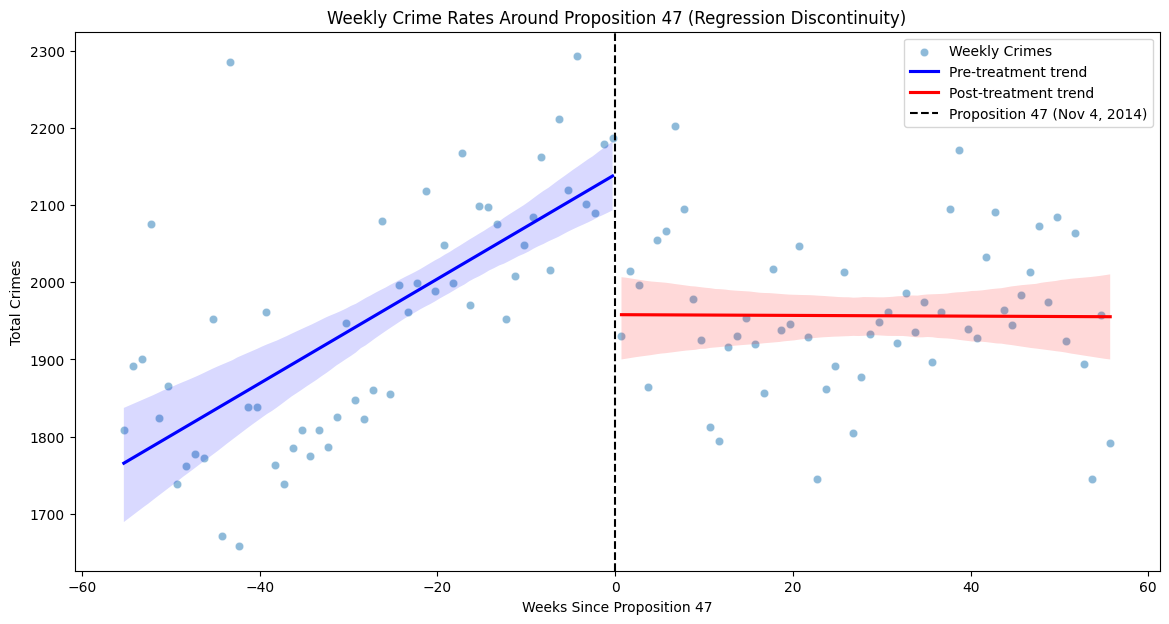

In [7]:
plt.figure(figsize=(14,7))
sns.scatterplot(x='weeks_since_cutoff', y='Total_Crimes', data=rd_data, alpha=0.5, label='Weekly Crimes')

# Regression lines pre/post cutoff
sns.regplot(x='weeks_since_cutoff', y='Total_Crimes', data=rd_data[rd_data['weeks_since_cutoff']<0], scatter=False, color='blue', label='Pre-treatment trend')
sns.regplot(x='weeks_since_cutoff', y='Total_Crimes', data=rd_data[rd_data['weeks_since_cutoff']>=0], scatter=False, color='red', label='Post-treatment trend')

# Cutoff line
plt.axvline(0, color='black', linestyle='--', label='Proposition 47 (Nov 4, 2014)')

plt.xlabel('Weeks Since Proposition 47')
plt.ylabel('Total Crimes')
plt.title('Weekly Crime Rates Around Proposition 47 (Regression Discontinuity)')
plt.legend()
plt.show()

__Key Observations:__

1. Pre-treatment trend (blue line):

    - Before Proposition 47, there was a clear upward trend in weekly crime rates.

    - This suggests that crime was increasing in the weeks leading up to the policy change.

2. Post-treatment trend (red line):

    - After the proposition was implemented, the trend in weekly crime rates flattened, indicating no continued increase.

    - The level of the red line appears lower than the projected continuation of the blue line, suggesting a drop or at least a halt in the increasing trend.

3. Discontinuity at cutoff (vertical dashed line):

    - There is a noticeable drop in the trend line exactly at the policy cutoff point, which supports the idea that Proposition 47 had an immediate and possibly causal effect in reducing or stabilizing crime rates.